# 05 - PCCA and TPT analysis

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to use PCCA++ to extract a coarse representation of the MSM.
We will further investigate how to use transition path theory (TPT) to follow the pathways of the processes.
When we want to analyze pathways, models with fewer states are more often desirable, since these are easier to understand.
PCCA++ allows us to assign the microstates directly to metastable macrostates and TPT uses this group assignment to compute fluxes and pathways.

Another method to get a model with fewer states are hidden Markov state models (HMM),
introduced in [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb).
In contrast to computing memberships of microstates to meta stable sets as in PCCA++,
in HMMs we directly obtain a model with fewer states.

While we will mostly rely on previously estimated/validated models, it will be helpful to understand the topics
- data loading/visualization ([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb))
- dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb))
- the estimation and validation process ([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb))

Here you can find literature on the used methods:
- <a id="ref-1" href="#cite-pcca_plus_plus">roeblitz-weber-14</a>
- <a id="ref-2" href="#cite-weinan-tpt">weinan-06</a>
- <a id="ref-3" href="#cite-metzner-msm-tpt">metzner-09</a>

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

---

⚠️ We have assigned the integer numbers $1 \dots $ `nstates` to PCCA++ metastable states.
As PyEMMA is written in Python, it internally indexes states starting from $0$.
In consequence, numbers in the code cells differ by $-1$ from the plot labels and markdown text.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)
We start by loading the data and the previously analyzed MSM  (estimated in [Notebook 04 ➜ 📓](04-msm-analysis.ipynb)) from disk:

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

msm = pyemma.load('nb4.pyemma', model_name='doublewell_msm')
bayesian_msm = pyemma.load('nb4.pyemma', model_name='doublewell_bayesian_msm')
cluster = pyemma.load('nb4.pyemma', model_name='doublewell_cluster')

/opt/Python-3.11.10/lib/python3.11/site-packages/pyemma/_base/serialization/pickle_extensions.py:58: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


We currently have an MSM with $50$ discrete states which was validated for two metastable states in the previous notebook.
Internally, the metastable states have been computed using the Perron Cluster Cluster Analysis (PCCA++) method <a id="ref-4" href="#cite-pcca_plus_plus">roeblitz-14</a>.
Let's analyze this in more detail here.
We can explicitly compute it by calling `msm.pcca()`.

In [3]:
nstates = 2
msm.pcca(nstates)

PCCA-134285225794256:[{'P': array([[0.04046725, 0.00208594, 0.0216938 , ..., 0.03400085, 0.00208594,
                             0.00125156],
                            [0.00232992, 0.03821062, 0.        , ..., 0.00069898, 0.03727872,
                             0.02120222],
                            [0.05514313, 0.        , 0.01802757, ..., 0.03870625, 0.00583245,
                             0.00106044],
                            ...,
                            [0.05096934, 0.00093809, 0.02282677, ..., 0.03627267, 0.00187617,
                             0.00187617],
                            [0.00207297, 0.03316744, 0.00228026, ..., 0.00124378, 0.03233831,
                             0.02383908],
                            [0.00218024, 0.03306689, 0.00072675, ..., 0.00218024, 0.0417879 ,
                             0.02325581]]),
                      'm': None}]

PCCA++ computes membership distributions, i.e., probabilities of micro-states to belong to the same metastable state.
It does so by using the properties of slow processes in eigenvector space.
Let us visualize the membership distributions in the same fashion as before:

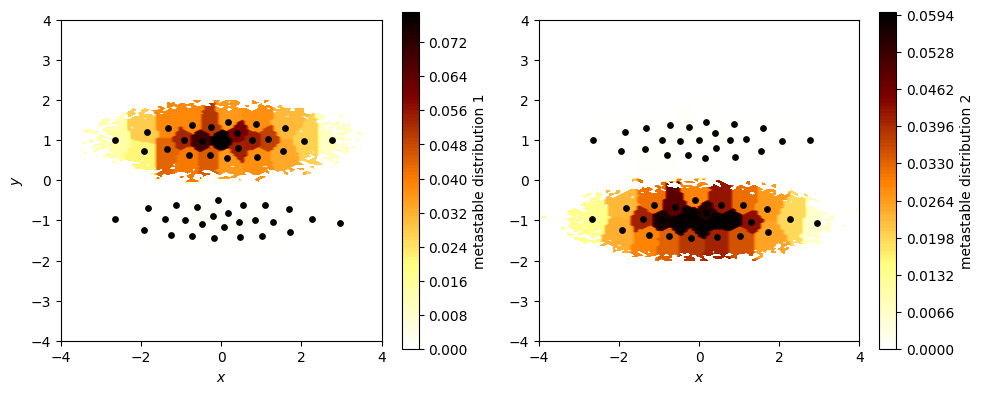

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T, msm.metastable_distributions[i][cluster.dtrajs[0]], ax=ax, cmap='afmhot_r', 
        mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
    ax.scatter(*cluster.clustercenters.T, s=15, c='k')
    ax.set_xlabel('$x$')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
axes[0].set_ylabel('$y$')
fig.tight_layout()

As expected, PCCA++ has assigned metastable states to the basins of the double well.
Since PCCA++, in simplified words, does a clustering in eigenvector space and the first eigenvector separated these states already, the nice separation comes to no surprise.

It is important to note, though, that PCCA++ in general does not yield a coarse transition matrix.
How to obtain this will be covered in [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb).
However, we can compute mean first passage times (MFPTs) and equilibrium probabilities on the metastable sets and extract representative structures.

The stationary probability of metastable states can simply be computed by summing over all of its micro-states
(please note that the PCCA++ object returned by `msm.pcca()` also has a convenience function to do that.)

In [5]:
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.439534
π_2 = 0.560466


We use the `mfpt()` method of the original MSM object to compute MFPTs between pairs of metastable sets
(accessible via the `metastable_sets` attribute of the MSM object). 

In [6]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / steps:


,1,2
1,0.00,16.06
2,20.47,0.00


As described above, the errors can be estimated from the Bayesian MSM.
Instead of just printing means and confidence intervals, let's compute the samples explicitly and histogram them.

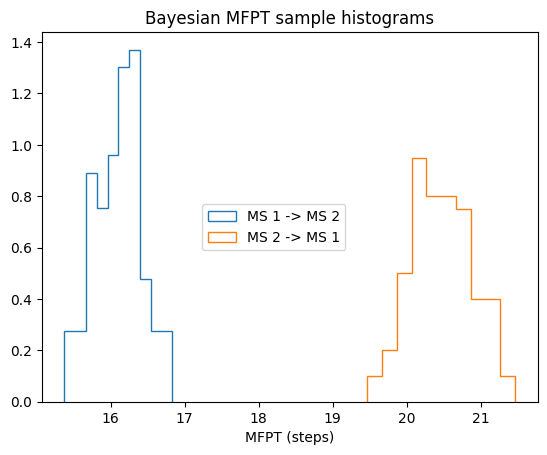

In [7]:
mfpt_sample = np.zeros((nstates, nstates, bayesian_msm.nsamples))
for i in range(nstates):
    for j in range(nstates):
        mfpt_sample[i, j] = bayesian_msm.sample_f(
            'mfpt',
            msm.metastable_sets[i],
            msm.metastable_sets[j])

fig, ax = plt.subplots()
ax.hist(mfpt_sample[0, 1], histtype='step', label='MS 1 -> MS 2', density=True)
ax.hist(mfpt_sample[1, 0], histtype='step', label='MS 2 -> MS 1', density=True)
ax.set_xlabel('MFPT (steps)')
ax.set_title('Bayesian MFPT sample histograms')
fig.legend(loc=10);

We clearly see that there is no overlap of the distributions approximated by the Bayesian MSM.

To do a more detailed analysis of the transition paths, we make use of transition path theory (TPT) in its MSM formulation.
We first analyze the flux between the two metastable sets:

In [8]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[1]
flux = pyemma.msm.tpt(msm, A, B)

In TPT, many properties are derived from the committor functions.
They describe the probability of reaching a set $A$ before set $B$ as a function of some state $x$.
In order to understand this, we plot the committor of the previously defined sets as a function of the cluster centers:

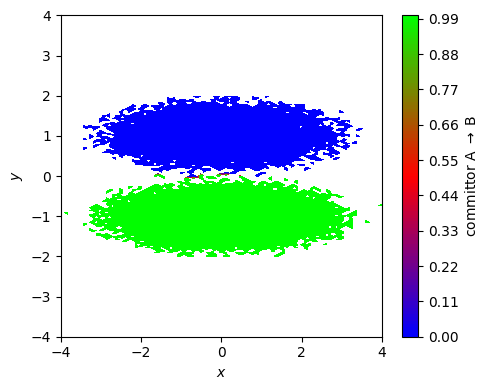

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))
pyemma.plots.plot_contour(
    *data.T,
    flux.committor[cluster.dtrajs[0]],
    ax=ax,
    cmap='brg', 
    mask=True,
    cbar_label=r'committor A $\to$ B')
ax.set_xlabel('$x$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
ax.set_ylabel('$y$')
fig.tight_layout()

We see that the committor for the double well data approximates a step function between the two basins.
In other words, the probability of transitioning from metastable state $A$ to $B$ is only $1$ if we already are in state $B$.
If we are in $A$, it is $0$ by definition.
The clustering did not resolve the transition region, so this particular example does not provide more information.
In the next example we will see more.

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)

Again, we load the model that we have estimated previously.

In [10]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

msm = pyemma.load('nb4.pyemma', model_name='ala2_msm')
bayesian_msm = pyemma.load('nb4.pyemma', model_name='ala2_bayesian_msm')
cluster = pyemma.load('nb4.pyemma', model_name='ala2_cluster')

# not to be used in MSM estimation (artificical transitions between individual trajectories)!
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

In the previous [Notebook 04 ➜ 📓](04-msm-analysis.ipynb), we saw that four metastable states are a reasonable choice for our MSM.
We, thus, perform PCCA++ with this number of states for further analysis and print out the stationary probabilities of the metastable sets:

In [11]:
nstates = 4
msm.pcca(nstates)
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.001484
π_2 = 0.028380
π_3 = 0.328156
π_4 = 0.641980


We visualize the metastable memberships:

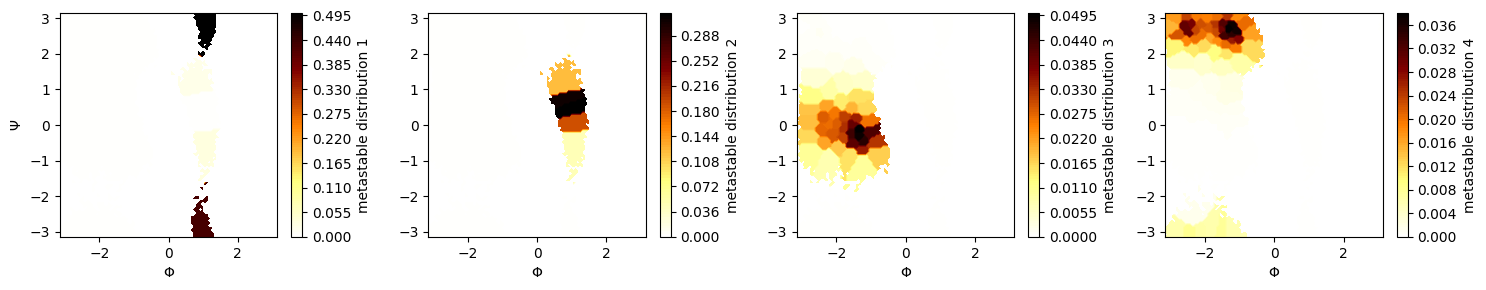

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('$\Phi$')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

PCCA++ nicely separates the high-density regions and we find that each of the basins was assigned a metastable set.
This indicates that our projection indeed describes the slow dynamics.

We concatenate all three discrete trajectories and obtain a single trajectory of metastable states which we use to visualize the metastable state memberships of all datapoints.
We further compute the state with the highest membership to a PCCA metastable state to plot a state label there.

⚠️ Please remember that the concatenated discrete trajectories (dtrajs) are not meant to be used for MSM estimation (artificial transitions), but only for visualization and indexing purposes!

In [13]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

Now, we use the `mfpt()` method of the MSM object to compute MFPTs between pairs of metastable sets and compute the inverse MFPTs for visualization purposes:

In [14]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

We visualize our model in backbone torsion space:

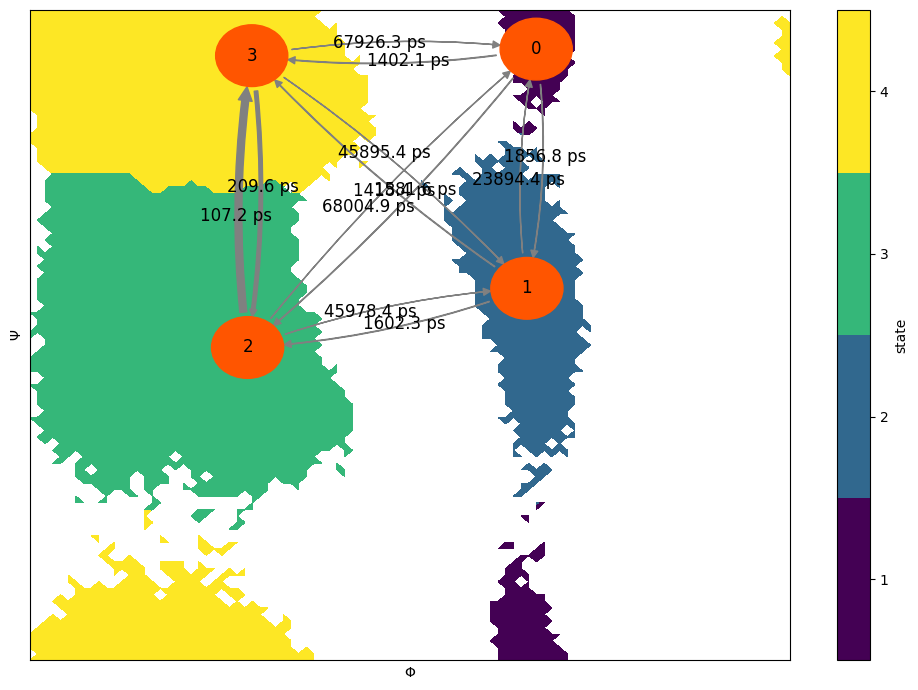

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *data_concatenated.T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    size=12,
    show_frame=True,
    ax=ax)

ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

Have you noticed how well the metastable state coloring agrees with the eigenvector visualization of the three slowest processes?

If we could afford a shorter lag time, we might even be able to resolve more processes and, thus,
subdivide the metastable states three and four.
We show how to do this with HMMs in [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb).

Now we define a small function to visualize samples of metastable states with NGLView.

In [16]:
def visualize_metastable(samples, cmap, selection='backbone'):
    """ visualize metastable states
    Parameters
    ----------
    samples: list of mdtraj.Trajectory objects
        each element contains all samples for one metastable state.
    cmap: matplotlib.colors.ListedColormap
        color map used to visualize metastable states before.
    selection: str
        which part of the molecule to selection for visualization. For details have a look here:
        http://mdtraj.org/latest/examples/atom-selection.html#Atom-Selection-Language
    """
    import nglview
    from matplotlib.colors import to_hex

    widget = nglview.NGLWidget()
    widget.clear_representations()
    ref = samples[0]
    for i, s in enumerate(samples):
        s = s.superpose(ref)
        s = s.atom_slice(s.top.select(selection))
        comp = widget.add_trajectory(s)
        comp.add_ball_and_stick()

    # this has to be done in a separate loop for whatever reason...
    x = np.linspace(0, 1, num=len(samples))
    for i, x_ in enumerate(x):
        c = to_hex(cmap(x_))
        widget.update_ball_and_stick(color=c, component=i, repr_index=i)
        widget.remove_cartoon(component=i)
    return widget

We now sample some representative structures and visualize these with the aid of NGLView.
For the sake of clarity, we draw only the backbone atoms.
Since we have obtained several samples for each metastable state, you can click the play button to iterate over all samples.
For each iteration, the samples of all four states will be drawn.
You can double click the molecule to show it at full screen.
Press escape to go back. 

In [17]:
cmap = mpl.cm.get_cmap('viridis', nstates)

my_samples = [pyemma.coordinates.save_traj(files, idist, outfile=None, top=pdb)
              for idist in msm.sample_by_distributions(msm.metastable_distributions, 50)]

visualize_metastable(my_samples, cmap, selection='backbone')

/tmp/ipykernel_2427670/3783525048.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis', nstates)


Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

NGLWidget(max_frame=49)

Coming back to TPT, we now have more than two metastable states and can expect more insights from analyzing the transition paths.
As an example, we will focus on the committor between metastable sets $0$ and $3$ as defined above.

In [18]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[3]
flux = pyemma.msm.tpt(msm, A, B)

Before we go on with the visualization, let's coarse grain the flux with the metastable sets estimated with PCCA++:

In [19]:
cg, cgflux = flux.coarse_grain(msm.metastable_sets)

We now show an overlay of the committor probabilities and the most likely transition path from the coarse graining TPT:

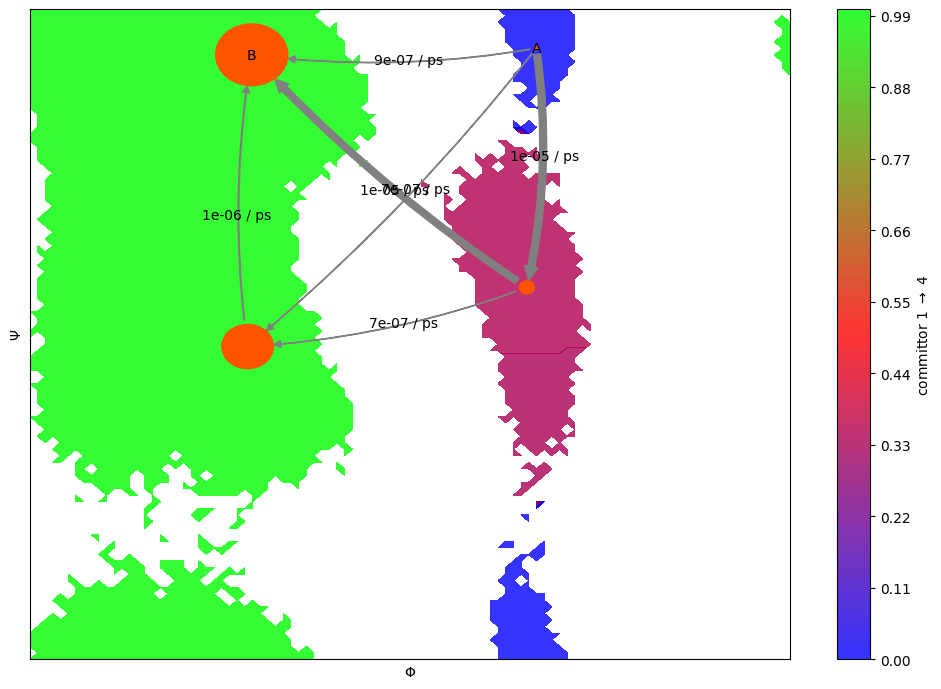

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *data_concatenated.T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 1 $\to$ 4',
    alpha=0.8,
    zorder=-1);

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    state_labels=['A','' ,'', 'B'], 
    ax=ax,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    arrow_label_format='%2.e / ps');

ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

First, the color map shows us a region with committor probability $\approx 0.5$.
This indicates that this particular metastable state is a transition state in the pathway from $A$ to $B$.
Second, the `plot_flux()` function displays the most likely transition pathway along this path.
There are other, less likely pathways included in the plot as well.
The arrow thickness indicates the flux between the states.

We can decompose the flux into these individual pathways by:

In [21]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

percentage       	path
-------------------------------------
0.842  	 [1 2 4]
0.06  	 [1 4]
0.052  	 [1 2 3 4]
0.046  	 [1 3 4]


As expected, about $85\%$ of the flux goes through only one pathway.
To get a cleaner picture, the `plot_flux()` function supports a `minflux` keyword argument that can be increased to exclude very low fluxes from the plot.

#### Exercise 1

Define a `featurizer` that loads the heavy atom coordinates and load the data into memory.
Also load the TICA object from [Notebook 04 ➜ 📓](04-msm-analysis.ipynb) to transform the featurized data.
Further, the estimated MSM, Bayesian MSM, and Cluster objects should be loaded from disk. 

In [ ]:
feat = #FIXME
feat. #FIXME
data = #FIXME

tica = #FIXME
tica_output = tica.transform(data)
tica_concatenated = np.concatenate(tica_output)

msm = #FIXME
bayesian_msm = #FIXME

cluster = #FIXME
dtrajs_concatenated = #FIXME

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

tica = pyemma.load('nb4.pyemma', model_name='ala2tica_tica')
tica_output = tica.transform(data)
tica_concatenated = np.concatenate(tica_output)

msm = pyemma.load('nb4.pyemma', model_name='ala2tica_msm')
bayesian_msm = pyemma.load('nb4.pyemma', model_name='ala2tica_bayesian_msm')

cluster = pyemma.load('nb4.pyemma', model_name='ala2tica_cluster')
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

#### Exercise 2

Do a PCCA++ analysis of the MSM with four metastable states,
compute the probability of the metastable sets, and visualize the metastable state memberships.

In [ ]:
nstates = 4
#FIXME (PCCA)

for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, )) #FIXME

    
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

###### Solution

In [ ]:
nstates = 4
msm.pcca(nstates)

for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

Did you guess the metastable states correctly?

Note the similarities between the MSM built from the backbone torsions and the MSM built from the TICA projection of heavy atom distances.
Even though we started from different features, both models found the same kinetic information in the data.

#### Exercise 3

Compute the pairwise MFPTs and transition rates, and visualize the resulting kinetic network.

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = #FIXME

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [4, 0], [2, 4], [6, 4]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=12);

###### Solution

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [4, 0], [2, 4], [6, 4]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=12);

#### Exercise 4
Compute the TPT object, coarse grain it onto the PCCA++ metastable sets and visualize the flux along with the committor probabilities.

In [ ]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[3]
flux = #FIXME

cg, cgflux = #FIXME

highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *tica_concatenated.T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 1 $\to$ 4',
    alpha=0.8,
    zorder=-1)

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    ax=ax,
    show_committor=False,
    figpadding=0.2,
    state_labels=['A', '', '', 'B'],
    arrow_label_format='%2.e / ps')

ax.set_aspect('equal')
ax.set_xlim(tica_concatenated[:, 0].min(), tica_concatenated[:, 0].max())
ax.set_ylim(tica_concatenated[:, 1].min(), tica_concatenated[:, 1].max())

###### Solution

In [ ]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[3]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *tica_concatenated.T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 1 $\to$ 4',
    zorder=-1)

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    ax=ax,
    show_committor=False,
    figpadding=0.2,
    state_labels=['A', '', '', 'B'],
    arrow_label_format='%2.e / ps')

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_aspect('equal')
ax.set_xlim(tica_concatenated[:, 0].min(), tica_concatenated[:, 0].max())
ax.set_ylim(tica_concatenated[:, 1].min(), tica_concatenated[:, 1].max())
fig.tight_layout()

## Wrapping up
In this notebook, we have learned how to use PCCA++ using an existing MSM and how to extract kinetic information from the model.
In detail, we have used
- the `pcca()` method of an MSM object to find metastable states,
- the `mfpt()` method of an MSM object to compute mean first passage times between metastable states which, in turn, are accessible via
- the `metastable_sets` and `metastable_assignments` attributes of an MSM object.

For visualizing MSMs or kinetic networks we used
- `pyemma.plots.plot_density()`, `pyemma.plots.plot_contour()` and
- `pyemma.plots.plot_network()`.

## References

<a id="cite-pcca_plus_plus"/><sup><a href=#ref-1>[^]</a><a href=#ref-4>[^]</a></sup>Susanna Röblitz and Marcus Weber. 2013. _Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification_. [URL](https://doi.org/10.1007/s11634-013-0134-6)

<a id="cite-weinan-tpt"/><sup><a href=#ref-2>[^]</a></sup>Weinan E. and Eric Vanden-Eijnden. 2006. _Towards a Theory of Transition Paths_. [URL](https://doi.org/10.1007/s10955-005-9003-9)

<a id="cite-metzner-msm-tpt"/><sup><a href=#ref-3>[^]</a></sup>Philipp Metzner and Christof Schütte and Eric Vanden-Eijnden. 2009. _Transition Path Theory for Markov Jump Processes_. [URL](https://doi.org/10.1137/070699500)

